In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import sys
import main_ode

import seaborn as sns
# Set seaborn style as default
sns.set(style="whitegrid")
# Adjust font sizes globally
plt.rcParams.update({
    "font.size": 14,  # Base font size
    "axes.titlesize": 16,  # Title font size
    "axes.labelsize": 14,  # Label font size
    "xtick.labelsize": 12,  # X-axis tick label size
    "ytick.labelsize": 12,  # Y-axis tick label size
    "legend.fontsize": 12  # Legend font size
})

SLURM_CPUS_PER_TASK: 0
OMP_NUM_THREADS: 0
os.cpu_count(): 10
[JAX CONFIG] Using 10 CPU threads


In [45]:
"""
we first test the sgn_mods
"""
def covariance(Q_1, Q_2, Q_12, J_1, J_2, S):
    cov = [[Q_1, Q_12, J_1], [Q_12, Q_2, J_2], [J_1, J_2, S]]
    return np.array(cov)

def sample_fields(cov, n_samples=1000):
    mean = [0, 0, 0]
    samples = np.random.multivariate_normal(mean, cov, n_samples)
    return samples

def sample_batch(cov, n_samples=1000):
    samples = sample_fields(cov, n_samples)
    h_1 = samples[:, 0]
    h_2 = samples[:, 1]
    x = samples[:, 2]
    return h_1, h_2, x

def conditional_gaussian(mean, cov, given_index, given_value):
    """
    Compute conditional Gaussian distribution:
    X ~ N(mean, cov)
    Condition on X[given_index] = given_value
    
    Returns (cond_mean, cond_cov)
    """
    idx = np.arange(len(mean))
    idx2 = np.delete(idx, given_index)

    # Partition the mean and covariance
    
    Sigma11 = cov[given_index, given_index]
    Sigma12 = cov[given_index, idx2]
    Sigma21 = cov[idx2, given_index]
    Sigma22 = cov[np.ix_(idx2, idx2)]

    # Conditional mean and covariance
    cond_cov = Sigma22 - np.outer(Sigma21, Sigma12) / Sigma11
    
    return cond_cov

In [ ]:
#sample batch of vectors:
Q_1, Q_2, Q_12, J_1, J_2, S = 0.8, 0.9, -0.6, -0.7, 0.5, 1
lambd, sigma, nu = sample_batch(covariance(Q_1, Q_2, Q_12, J_1, J_2, S), n_samples=500000)

#sample conditioned on lamd = 0


In [52]:
cond_cov_lambd = conditional_gaussian([0, 0, 0], covariance(Q_1, Q_2, Q_12, J_1, J_2, S), 
                                                 given_index=0, given_value=0)

cond_cov_sigma = conditional_gaussian([0, 0, 0], covariance(Q_1, Q_2, Q_12, J_1, J_2, S), 
                                                 given_index=1, given_value=0)

cond_cov_nu = conditional_gaussian([0, 0, 0], covariance(Q_1, Q_2, Q_12, J_1, J_2, S), 
                                                 given_index=2, given_value=0)


sigma_cond_lambd, nu_cond_lambd = np.random.multivariate_normal([0, 0], cond_cov_lambd, 500000).T
lambd_cond_sigma, nu_cond_sigma = np.random.multivariate_normal([0, 0], cond_cov_sigma, 500000).T
lambd_cond_nu, sigma_cond_nu = np.random.multivariate_normal([0, 0], cond_cov_nu, 500000).T

In [67]:
def Rho1nu_2(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (J_1 * Q_2 - J_2 * Q_12) / np.sqrt((Q_1 * Q_2- Q_12**2) * (Q_2 * S - J_2**2))

def Rho2nu_1(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (J_2 * Q_1 - J_1 * Q_12) / np.sqrt((Q_1 * Q_2- Q_12**2) * (Q_1 * S - J_1**2))

def Rho12_nu(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (Q_12 * S - J_1 * J_2) / np.sqrt((Q_1 * S - J_1**2) * (Q_2 * S - J_2**2))

def RhoXY_Z(Q_x, Q_y, Q_z, J_xz, J_yz, J_xy):
    return (J_xy * Q_z - J_xz * J_yz) / np.sqrt((Q_x * Q_z - J_xz**2) * (Q_y * Q_z - J_yz**2))


def Sgn2Nu_mod1(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
              + Q_12 / np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))
                + J_1 / np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))))

def Sgn1Nu_mod2(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))
              + Q_12 / np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
                + J_2 / np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))))

def Sgn12_modNu(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))
              + J_1 / np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
                + J_2 / np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))))


sgn12_modNu = Sgn12_modNu(Q_1, Q_2, S, J_1, J_2, Q_12)
sgn1Nu_mod2 = Sgn1Nu_mod2(Q_1, Q_2, S, J_1, J_2, Q_12)
sgn2Nu_mod1 = Sgn2Nu_mod1(Q_1, Q_2, S, J_1, J_2, Q_12)

sgn12_modNu_samples = np.sign(lambd * sigma) * np.abs(nu)
sgn1Nu_mod2_samples = np.sign(lambd * nu) * np.abs(sigma)
sgn2Nu_mod1_samples = np.sign(sigma * nu) * np.abs(lambd)

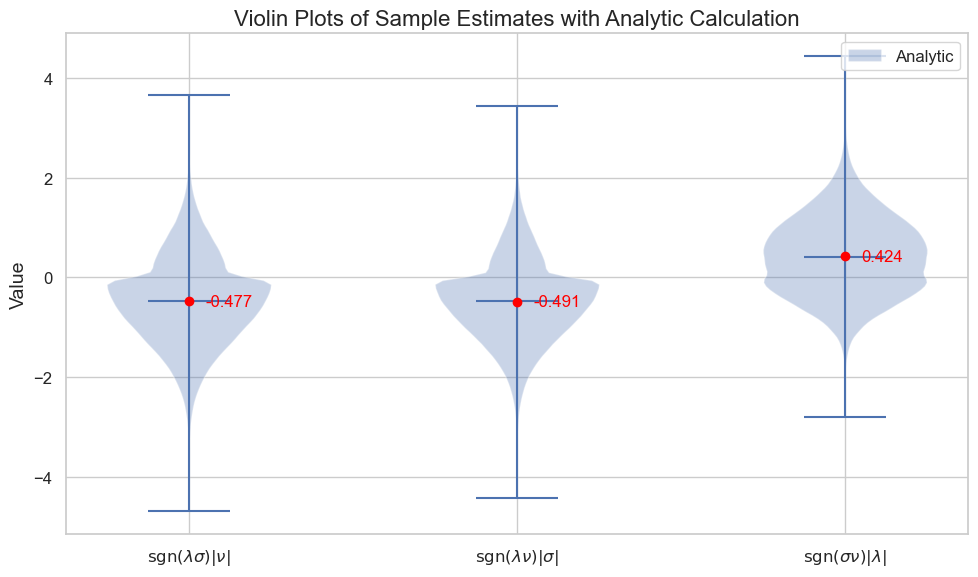

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    sgn12_modNu_samples,
    sgn1Nu_mod2_samples,
    sgn2Nu_mod1_samples
]
labels = [
    r"$\mathrm{sgn}(\lambda\sigma)|\nu|$",
    r"$\mathrm{sgn}(\lambda\nu)|\sigma|$",
    r"$\mathrm{sgn}(\sigma\nu)|\lambda|$"
]
analytics = [
    float(sgn12_modNu),
    float(sgn1Nu_mod2),
    float(sgn2Nu_mod1)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels)

# Annotate analytic values
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic"], loc="upper right")
plt.tight_layout()
plt.show()

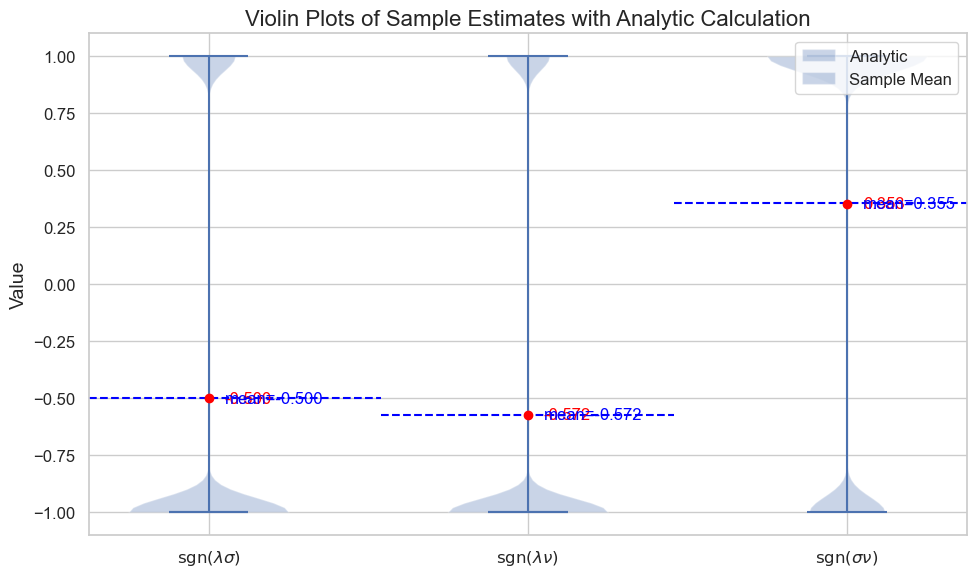

In [31]:
"""
we do the same thing for the next set of expectations
"""
sgn12 = main_ode.SgnXY(Q_1, Q_2, Q_12)
sgnNu1 = main_ode.SgnXY(Q_1, S, J_1)
sgnNu2 = main_ode.SgnXY(Q_2, S, J_2)

sgn12_samples = np.sign(lambd * sigma)
sgnNu1_samples = np.sign(lambd * nu)
sgnNu2_samples = np.sign(sigma * nu)

fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    sgn12_samples,
    sgnNu1_samples,
    sgnNu2_samples
]
labels = [
    r"$\mathrm{sgn}(\lambda\sigma)$",
    r"$\mathrm{sgn}(\lambda\nu)$",
    r"$\mathrm{sgn}(\sigma\nu)$"
]
analytics = [
    float(sgn12),
    float(sgnNu1),
    float(sgnNu2)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels)

# Annotate analytic values
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)
    # Show mean of samples
    sample_mean = np.mean(data[i])
    ax.axhline(sample_mean, color='blue', linestyle='--', xmin=(i)/3, xmax=(i+1)/3, label='Sample Mean' if i == 0 else "")
    ax.text(i+1+0.05, sample_mean, f"mean={sample_mean:.3f}", color='blue', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic", "Sample Mean"], loc="upper right")
plt.tight_layout()
plt.show()

In [32]:
"""
next set of expectations
"""
sgn1_Nu = main_ode.SgnX_Y(Q_1, J_1)
sgn2_Nu = main_ode.SgnX_Y(Q_2, J_2)
sgnNu_1 = main_ode.SgnX_Y(S, J_1)
sgnNu_2 = main_ode.SgnX_Y(S, J_2)
sgn1_2 = main_ode.SgnX_Y(Q_1, Q_12)
sgn2_1 = main_ode.SgnX_Y(Q_2, Q_12)

sgn1_Nu_samples = np.sign(lambd) * nu
sgn2_Nu_samples = np.sign(sigma) * nu
sgnNu_1_samples = np.sign(nu) * lambd
sgnNu_2_samples = np.sign(nu) * sigma
sgn1_2_samples = np.sign(lambd) * sigma
sgn2_1_samples = np.sign(sigma) * lambd

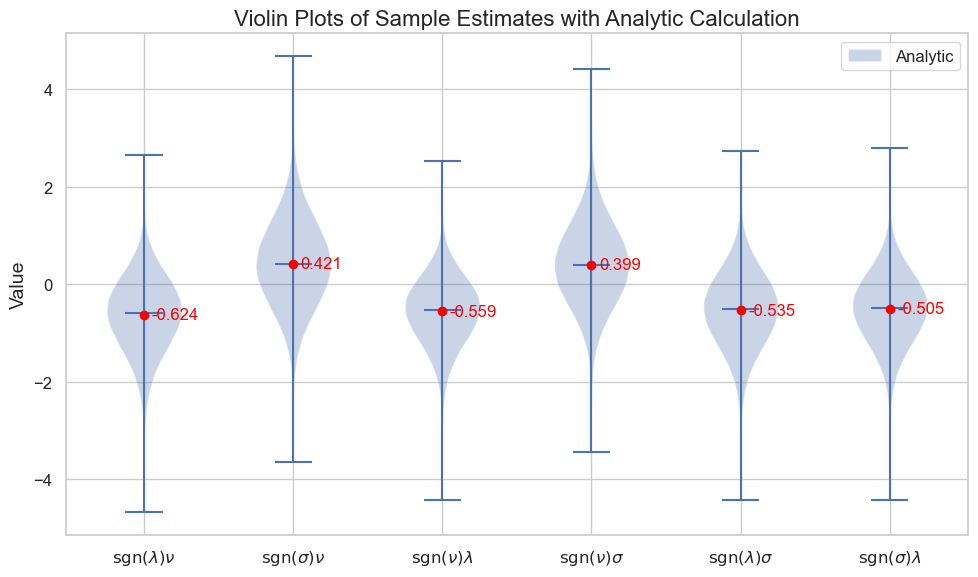

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    sgn1_Nu_samples,
    sgn2_Nu_samples,
    sgnNu_1_samples,
    sgnNu_2_samples,
    sgn1_2_samples,
    sgn2_1_samples
]
labels = [
    r"$\mathrm{sgn}(\lambda)\nu$",
    r"$\mathrm{sgn}(\sigma)\nu$",
    r"$\mathrm{sgn}(\nu)\lambda$",
    r"$\mathrm{sgn}(\nu)\sigma$",
    r"$\mathrm{sgn}(\lambda)\sigma$",
    r"$\mathrm{sgn}(\sigma)\lambda$"
]
analytics = [
    float(sgn1_Nu),
    float(sgn2_Nu),
    float(sgnNu_1),
    float(sgnNu_2),
    float(sgn1_2),
    float(sgn2_1)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(labels)

# Annotate analytic values
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic"], loc="upper right")
plt.tight_layout()
plt.show()

In [36]:
"""
now with next expectations
"""

P_1 = main_ode.HeaviLambdaNu(J_1, Q_1)
P_2 = main_ode.HeaviLambdaNu(J_2, Q_2)
P_12 = main_ode.Heavi12_heavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S)
P_12_collab = main_ode.Heavi12_negheavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S)

P_1_samples = np.heaviside(lambd * nu, 0)
P_2_samples = np.heaviside(sigma * nu, 0)
P_12_samples = np.heaviside(lambd * sigma, 0) * np.heaviside(lambd * nu, 0)
P_12_collab_samples = np.heaviside(lambd * sigma, 0) * np.heaviside(-lambd * nu, 0)

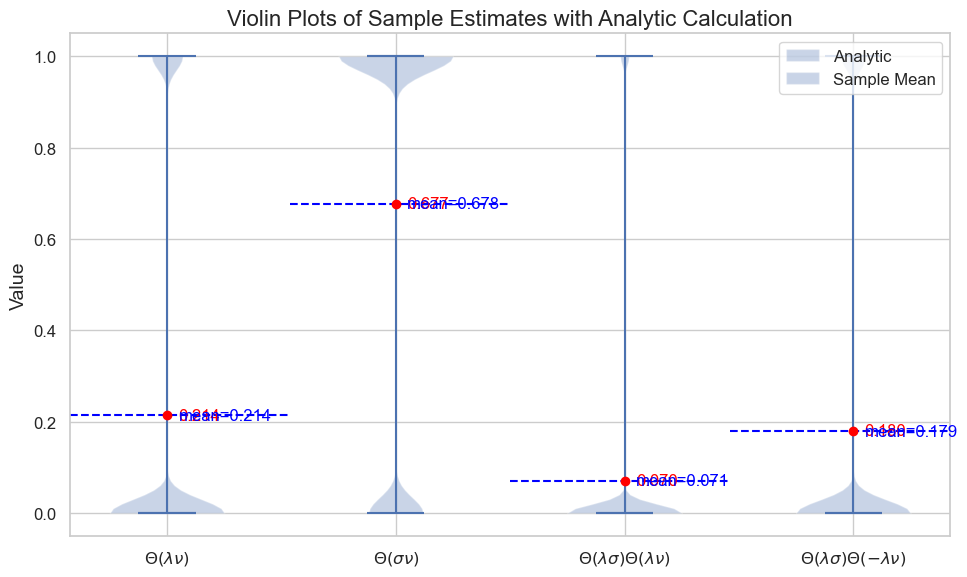

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    P_1_samples,
    P_2_samples,
    P_12_samples,
    P_12_collab_samples
]
labels = [
    r"$\Theta(\lambda\nu)$",
    r"$\Theta(\sigma\nu)$",
    r"$\Theta(\lambda\sigma)\Theta(\lambda\nu)$",
    r"$\Theta(\lambda\sigma)\Theta(-\lambda\nu)$"
]
analytics = [
    float(P_1),
    float(P_2),
    float(P_12),
    float(P_12_collab)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels)

# Annotate analytic values and sample means
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)
    # Show mean of samples
    sample_mean = np.mean(data[i])
    ax.axhline(sample_mean, color='blue', linestyle='--', xmin=(i)/4, xmax=(i+1)/4, label='Sample Mean' if i == 0 else "")
    ax.text(i+1+0.05, sample_mean, f"mean={sample_mean:.3f}", color='blue', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic", "Sample Mean"], loc="upper right")
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
epochs = 1000
savepoints = 200

save_epochs = np.unique(np.logspace(0, np.log10(epochs - 1), num=savepoints, dtype=int))
save_epochs = np.array(save_epochs)
deltas = np.diff(save_epochs, prepend=0)  # number of steps between savepoints
num_saves = save_epochs.shape[0]

print(len(deltas))
print(len(save_epochs))

130
130


In [3]:
print(save_epochs)
print(deltas)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  38
  39  41  42  43  45  47  48  50  52  54  56  58  60  62  64  66  69  71
  73  76  79  82  84  87  91  94  97 101 104 108 112 116 120 124 128 133
 138 143 148 153 158 164 170 176 182 188 195 202 209 216 224 232 240 249
 258 267 276 286 296 306 317 329 340 352 365 378 391 405 419 434 449 465
 481 499 516 534 553 573 593 614 636 658 681 706 730 756 783 811 839 869
 900 932 964 999]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  1  1  1  1  1  1  2  1  2  1  1  2  2  1  2  2  2  2  2
  2  2  2  2  3  2  2  3  3  3  2  3  4  3  3  4  3  4  4  4  4  4  4  5
  5  5  5  5  5  6  6  6  6  6  7  7  7  7  8  8  8  9  9  9  9 10 10 10
 11 12 11 12 13 13 13 14 14 15 15 16 16 18 17 18 19 20 20 21 22 22 23 25
 24 26 27 28 28 30 31 32 32 35]
